In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
import re
import pickle
import shap
from util import *
from plot_results import *

shap.initjs()

read preprocessed data files

In [15]:
# X_train =pd.read_csv(".....csv")
# X_test = pd.read_csv(".....csv")
# y_train = pd.read_csv(".....csv")
# y_test = pd.read_csv(".....csv")

define hyperparameters

In [4]:
penalty = ["l2",'l1']
C = np.logspace(-4, 4, 50)
solver= ["sag","saga","liblinear"]
max_iter= list(range(40, 300))
    
hyperparameters = dict(C=C, penalty=penalty,max_iter=max_iter)

 model training: original model (full feature set)

In [5]:
model = RandomizedSearchCV(LogisticRegression(), hyperparameters, random_state=1, cv=5, verbose=0, n_jobs=-1)

model.fit(X_train, y_train)
print('Best model mean cross-validated score :', model.best_score_)

Best model mean cross-validated score : 0.8898986248160179


In [6]:
print("AUROC score on test set:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]) )

print("AUPRC score on test set:", average_precision_score(y_test, model.predict_proba(X_test)[:,1]) )

AUROC score on test set: 0.8263551153437196
AUPRC score on test set: 0.5593035600808932


In [7]:
df= X_test.copy()
df["y_truth"]= y_test.astype('int')
df["y_pred"]= model.predict_proba(X_test)[:,1]
result_roc, result_pr ,results_text=get_model_performance(df)

--------------
AUROC 0.826 ( 0.81 , 0.842 ) CI 95%
AUPRC 0.559 ( 0.523 , 0.596) CI 95% 


building parsimonious model (shap analysis on full feature set)

In [8]:
explainer = shap.Explainer(model.best_estimator_, X_train, feature_names=X_train.columns)
shap_values = explainer(X_train)

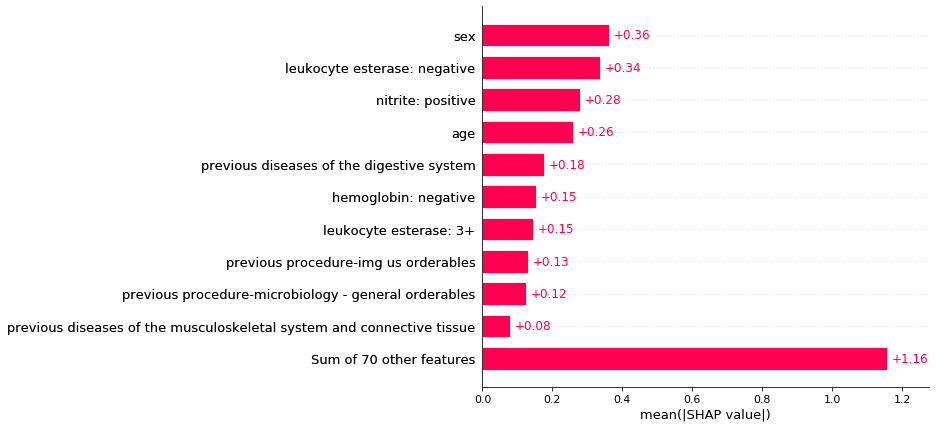

In [9]:
fig=plt.gcf()
shap.plots.bar(shap_values,max_display=11,show=False)
plt.savefig('shap_5_final_10^5.png',format = "png",dpi = 200,bbox_inches = 'tight')

viewing shap values

In [10]:
feature_names = shap_values.feature_names
shap_df = pd.DataFrame(shap_values.values, columns=feature_names)
vals = np.abs(shap_df.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['col_name', 'feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
# shap_importance.to_csv("shap_5_final.csv")
shap_importance.head()

,col_name,feature_importance_vals
7,sex,0.362825
72,leukocyte esterase: negative,0.337279
68,nitrite: positive,0.278228
0,age,0.257457
22,previous diseases of the digestive system,0.176547


In [11]:
parsimonious=list(shap_importance[:10].col_name.values)
print(parsimonious)

['sex', 'leukocyte esterase: negative', 'nitrite: positive', 'age', 'previous diseases of the digestive system', 'hemoglobin: negative', 'leukocyte esterase: 3+', 'previous procedure-img us orderables', 'previous procedure-microbiology - general orderables', 'previous diseases of the musculoskeletal system and connective tissue']


In [12]:
dipstick = [ 'nitrite: positive',
       'leukocyte esterase: 1+', 'leukocyte esterase: 2+',
       'leukocyte esterase: 3+', 'leukocyte esterase: negative',
       'leukocyte esterase: trace', 'hemoglobin: 1+', 'hemoglobin: 2+',
       'hemoglobin: 3+', 'hemoglobin: 4+', 'hemoglobin: negative',
       'hemoglobin: trace']

In [13]:
predicted_ouctomes = []
exp_name = ["Original Model","Parsimonious Model" ,"Disptick Model" ]
col_sets = [X_train.columns,parsimonious,dipstick]

true_ouctomes = []
df = pd.DataFrame()
X_train_ = X_train
X_test_= X_test
for i,j in zip(exp_name,col_sets):
    y_train_ = y_train
    y_test_= y_test
    print("Experiment using ",i)
    print("--------------------------------------------------------------------------------------------------")
    print("--------------------------------------------------------------------------------------------------")
    name= "model"+i
    name = RandomizedSearchCV(LogisticRegression(), hyperparameters, random_state=1, cv=5, verbose=0, n_jobs=-1)
    name.fit(X_train_[j], y_train_)
    coefficients = pd.concat([pd.DataFrame(X_train_[j].columns, columns = ["a"]),pd.DataFrame(np.transpose(name.best_estimator_.coef_), columns = ["b"])], axis = 1)
    coefficients.sort_values('b',ascending = False).to_csv("coefficients.csv")
    print('Best model mean cross-validated score :', name.best_score_)
    df = pd.DataFrame()
    df["y_truth"]= y_test_.astype('int')
    df["y_pred"]= name.predict_proba(X_test_[j])[:,1]
    result_roc, result_pr ,results_text=get_model_performance(df)
    predicted_ouctomes.append(name.predict_proba(X_test_[j])[:,1])
    true_ouctomes.append(y_test_)


Experiment using  Original Model
--------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------
Best model mean cross-validated score : 0.8898986248160179
--------------
AUROC 0.826 ( 0.81 , 0.843 ) CI 95%
AUPRC 0.559 ( 0.523 , 0.597) CI 95% 
Experiment using  Parsimonious Model
--------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------
Best model mean cross-validated score : 0.8921089548749123
--------------
AUROC 0.813 ( 0.797 , 0.83 ) CI 95%
AUPRC 0.548 ( 0.51 , 0.582) CI 95% 
Experiment using  Disptick Model
--------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------
Best model

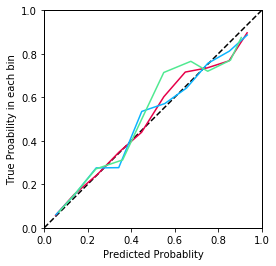

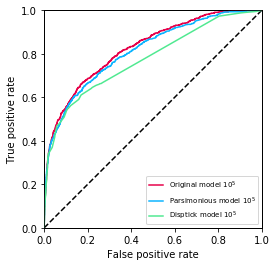

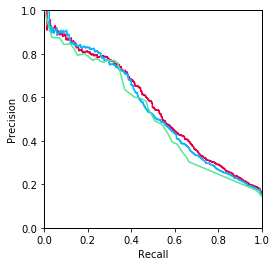

In [14]:
exp_name = ["Original model $10^5$","Parsimonious model $10^5$" ,"Disptick model $10^5$"]
plot_calibration_multi(exp_name,true_ouctomes,predicted_ouctomes, 10,"10^5")
plot_roc_multi(exp_name,true_ouctomes,predicted_ouctomes,"10^5")
plot_PRC_multi(exp_name,true_ouctomes,predicted_ouctomes,"10^5")